The following regressions are performed with all variables from the school data, and includes additional variables to the regressions.ipynb, including geographic location and National School Lunch Program status. The first set of regressions are performed without the charter school dummy, but the following set is. In both sets, OLS regressions are used initially, followed by Lasso and Ridge to determine the best predictors of test scores. 

Importing the necessary packages for the regressions.

In [89]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df_combined = pd.read_csv('combined_data/combined.csv')

In this cell, I drop rows with missing values in order to ensure the regressions work.

In [90]:
df_combined = df_combined.dropna()
print('Number of rows without missing data: ', df_combined.shape[0])
print('Number of charter and traditional schools:\n', df_combined['Charter School Dummy'].value_counts())

Number of rows without missing data:  10337
Number of charter and traditional schools:
 0    7705
1    2632
Name: Charter School Dummy, dtype: int64


Running an OLS regression on the input variables ('X') and output variable ('y').

In [91]:
# columns to be used for analysis
X = df_combined[['Total Students All Grades (Excludes AE)', 'Free and Reduced Lunch Students Percentage', 
                'Female Students Percentage', 'American Indian/Alaska Native Students Percentage', 
                'Asian or Asian/Pacific Islander Students Percentage', 'Hispanic Students Percentage', 
                'Black or African American Students Percentage', 
                'Nat. Hawaiian or Other Pacific Isl. Students Percentage', 'Two or More Races Students Percentage',
                'School Level: Primary', "School Level: Middle", 'Apache County', 'Cochise County', 'Coconino County', 'Gila County', 
                'Graham County', 'Greenlee County', 'La Paz County', 'Mohave County', 'Navajo County', 
                'Pima County', 'Pinal County', 'Santa Cruz County', 'Yavapai County', 'Yuma County',
                'NSLP: Yes, under CEO', 'NSLP: Yes, under Provision 2', 'NSLP: Yes, without Provision or CEO', 
                'NSLP: Yes, under Provision 3', 'Title I: Targeted Assistance Eligible School - No Program', 
                'Title I: Targeted Assistance School', 'Title I: Schoolwide Eligible - Targeted Assistance Program', 
                'Title I Schoolwide Eligible School - No Program', 'Title I: Schoolwide School', '2015', '2016', '2017', '2018', '2019']]
y = df_combined[['Average Percent Passing']]

# normalizes the predictor variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# splits the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20)

# performs OLS regression and summarizes regression
olsReg1 = sm.OLS(y_train,X_train).fit()
print(olsReg1.summary())

# uses regression to predict with test data
y_pred = olsReg1.predict(X_test)

# compares the predicted values to the actual values to evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R-squared:', r2)
print('Mean squared error:', mse)

                                   OLS Regression Results                                   
Dep. Variable:     Average Percent Passing   R-squared (uncentered):                   0.920
Model:                                 OLS   Adj. R-squared (uncentered):              0.920
Method:                      Least Squares   F-statistic:                              2434.
Date:                     Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                             11:38:42   Log-Likelihood:                         -32228.
No. Observations:                     8269   AIC:                                  6.453e+04
Df Residuals:                         8230   BIC:                                  6.481e+04
Df Model:                               39                                                  
Covariance Type:                 nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

Run a LASSO regression on the training data and search over different alpha parameters.

Best Alpha:  1e-06
MSE:  138.84070147184332


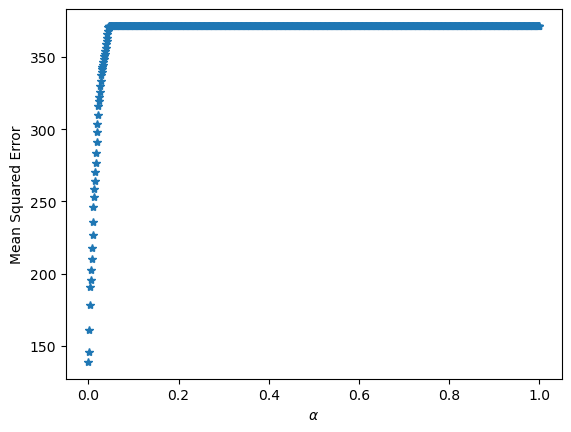

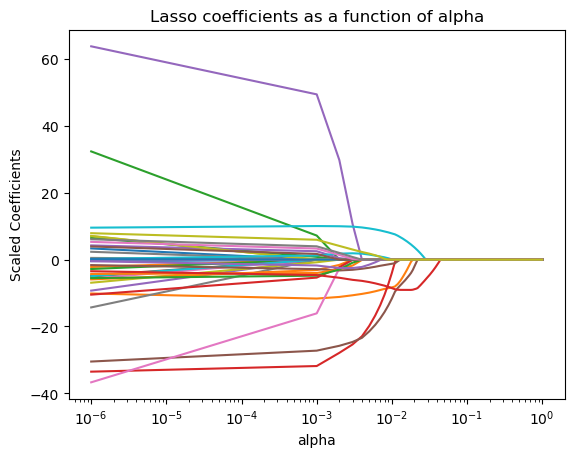

In [92]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
lasso_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    lassoReg = make_pipeline(Lasso(alpha=a * np.sqrt(X_train.shape[0])))
    lassoReg.fit(X_train, y_train)
    y_pred = lassoReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    lasso_coefs.append(lassoReg['lasso'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a

best_lasso_coefs = lasso_coefs[cv_errs.index(min(cv_errs))]
    
print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

# plots the coefficients over alpha values
ax = plt.gca()
ax.plot(alphas, lasso_coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Lasso coefficients as a function of alpha');

Run a Ridge Regression on the training data and search over different alpha parameters.

Best Alpha:  0.0010019999999999999
MSE:  138.54773047984676


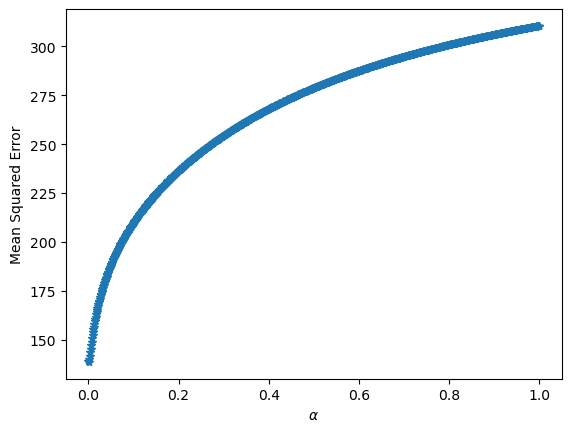

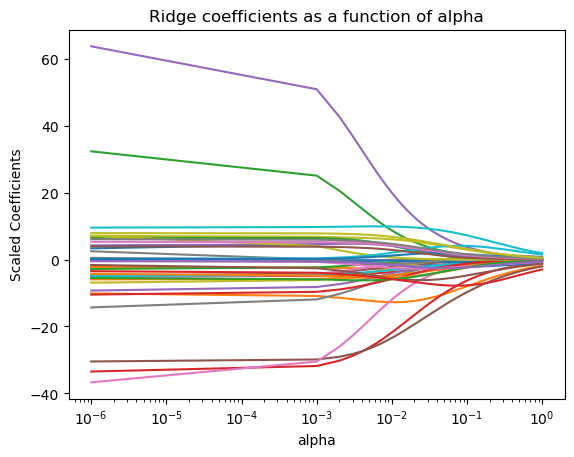

In [93]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
ridge_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    ridgeReg = make_pipeline(Ridge(alpha=a * X_train.shape[0]))
    ridgeReg.fit(X_train, y_train)
    y_pred = ridgeReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    ridge_coefs.append(ridgeReg['ridge'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a

best_ridge_coefs = ridge_coefs[cv_errs.index(min(cv_errs))]
    
print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

# plots the coefficients over alpha values
ax = plt.gca()
ax.plot(alphas, np.squeeze(ridge_coefs))
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Ridge coefficients as a function of alpha');

Compare the regression coefficients from the three different approaches.

In [94]:
# coef_comp = pd.DataFrame({'var': X.columns.tolist(), 
#                           'val_ols': olsReg1.params.tolist(),
#                           'val_lasso': best_lasso_coefs,
#                           'val_ridge': best_ridge_coefs[0]})
# print(coef_comp)

# creates new data frame with coefficients
coef_comp = pd.DataFrame({
    'Variable': X.columns.tolist(),
    'Without Charter Dummy': olsReg1.params.round(3)
})

# sets index to variable name
coef_comp.set_index('Variable', inplace=True)

# formats the table for Latex
print(coef_comp.style.format("{:.3f}").to_latex())

\begin{tabular}{lr}
 & Without Charter Dummy \\
Variable &  \\
Total Students All Grades (Excludes AE) & 6.673 \\
Free and Reduced Lunch Students Percentage & -8.366 \\
Female Students Percentage & 82.256 \\
American Indian/Alaska Native Students Percentage & -29.745 \\
Asian or Asian/Pacific Islander Students Percentage & 73.565 \\
Hispanic Students Percentage & -24.949 \\
Black or African American Students Percentage & -31.314 \\
Nat. Hawaiian or Other Pacific Isl. Students Percentage & 14.914 \\
Two or More Races Students Percentage & 18.071 \\
School Level: Primary & 10.876 \\
School Level: Middle & 1.181 \\
Apache County & 1.190 \\
Cochise County & -0.940 \\
Coconino County & -3.006 \\
Gila County & -6.674 \\
Graham County & -2.042 \\
Greenlee County & -2.720 \\
La Paz County & -13.616 \\
Mohave County & -3.940 \\
Navajo County & -2.396 \\
Pima County & 0.383 \\
Pinal County & -4.325 \\
Santa Cruz County & 8.061 \\
Yavapai County & -7.949 \\
Yuma County & 5.451 \\
NSLP: Yes, under

Follows the same steps as in the previous cells but with the input 'Chater School Dummy.' 

In [95]:
# columns to be used for analysis
X = df_combined[['Charter School Dummy', 'Total Students All Grades (Excludes AE)', 'Free and Reduced Lunch Students Percentage', 
                'Female Students Percentage', 'American Indian/Alaska Native Students Percentage', 
                'Asian or Asian/Pacific Islander Students Percentage', 'Hispanic Students Percentage', 
                'Black or African American Students Percentage', 
                'Nat. Hawaiian or Other Pacific Isl. Students Percentage', 'Two or More Races Students Percentage',
                'School Level: Primary', 'School Level: Middle', 'Apache County', 'Cochise County', 'Coconino County', 'Gila County', 
                'Graham County', 'Greenlee County', 'La Paz County', 'Mohave County', 'Navajo County', 
                'Pima County', 'Pinal County', 'Santa Cruz County', 'Yavapai County', 'Yuma County',
                'NSLP: Yes, under CEO', 'NSLP: Yes, under Provision 2', 'NSLP: Yes, without Provision or CEO', 
                'NSLP: Yes, under Provision 3', 'Title I: Targeted Assistance Eligible School - No Program', 
                'Title I: Targeted Assistance School', 'Title I: Schoolwide Eligible - Targeted Assistance Program', 
                'Title I Schoolwide Eligible School - No Program', 'Title I: Schoolwide School', '2015', '2016', '2017', '2018', '2019']]
y = df_combined[['Average Percent Passing']]

# normalizes the predictor variables
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# splits the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20)

# performs OLS regression and summarizes regression
olsReg2 = sm.OLS(y_train,X_train).fit()
print(olsReg2.summary())

# uses regression to predict with test data
y_pred = olsReg2.predict(X_test)

# compares the predicted values to the actual values to evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R-squared:', r2)
print('Mean squared error:', mse)

                                   OLS Regression Results                                   
Dep. Variable:     Average Percent Passing   R-squared (uncentered):                   0.918
Model:                                 OLS   Adj. R-squared (uncentered):              0.918
Method:                      Least Squares   F-statistic:                              2308.
Date:                     Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                             11:38:51   Log-Likelihood:                         -32284.
No. Observations:                     8269   AIC:                                  6.465e+04
Df Residuals:                         8229   BIC:                                  6.493e+04
Df Model:                               40                                                  
Covariance Type:                 nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025    

Best Alpha:  1e-06
MSE:  130.70850002903018


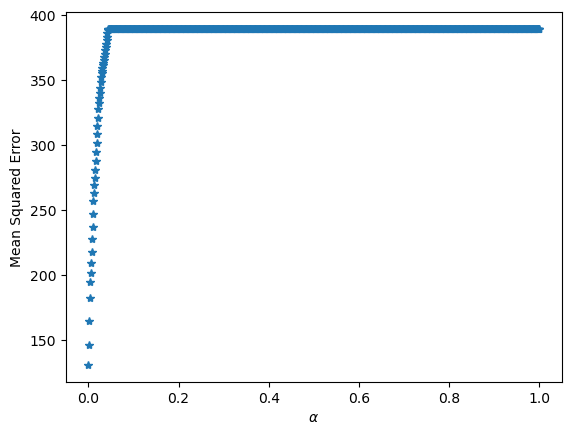

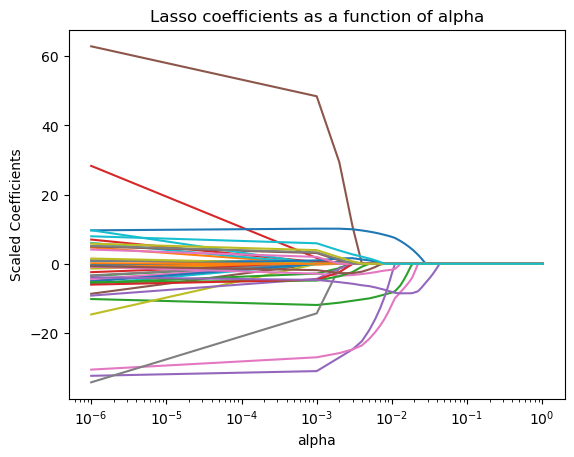

In [96]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
lasso_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    lassoReg = make_pipeline(Lasso(alpha=a * np.sqrt(X_train.shape[0])))
    lassoReg.fit(X_train, y_train)
    y_pred = lassoReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    lasso_coefs.append(lassoReg['lasso'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a

best_lasso_coefs = lasso_coefs[cv_errs.index(min(cv_errs))]
    
print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

ax = plt.gca()
ax.plot(alphas, lasso_coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Lasso coefficients as a function of alpha');


Best Alpha:  1e-06
MSE:  130.70793627651932


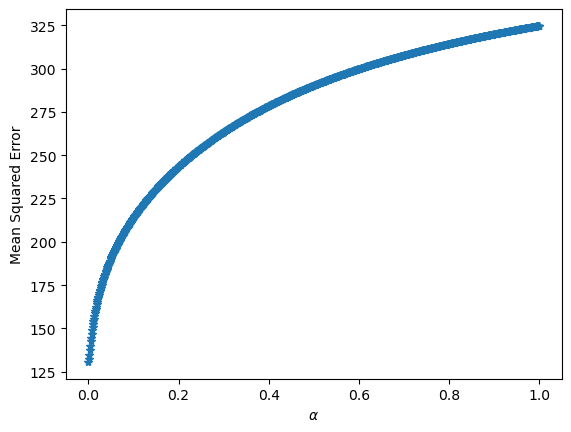

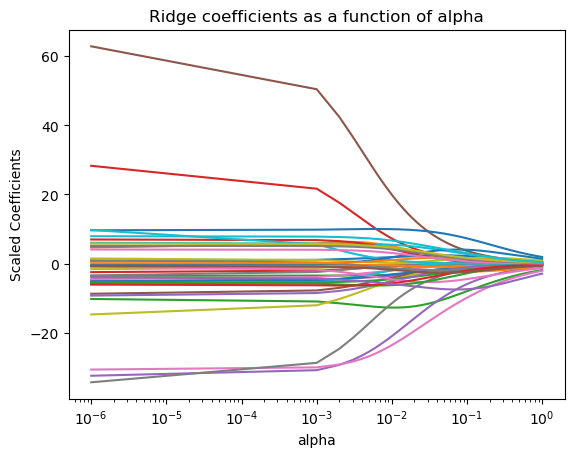

In [97]:
# constructs vector of alpha values
alphas = np.linspace(1e-6, 1, num=1000)

# constructs vectors to store mean prediction errors and coefficients
cv_errs = []
ridge_coefs = []
MSE = 500
bestalpha = 0

# loops for running ridge regression for different values of alpha
for a in alphas:
    ridgeReg = make_pipeline(Ridge(alpha=a * X_train.shape[0]))
    ridgeReg.fit(X_train, y_train)
    y_pred = ridgeReg.predict(X_test)
    cv_errs.append(mean_squared_error(y_test, y_pred))
    ridge_coefs.append(ridgeReg['ridge'].coef_)
    if mean_squared_error(y_test, y_pred) < MSE: 
        MSE = mean_squared_error(y_test, y_pred)
        bestalpha = a

best_ridge_coefs = ridge_coefs[cv_errs.index(min(cv_errs))]
    
print("Best Alpha: ", bestalpha)
print("MSE: ", MSE)

# plots the MSE against the values of alphas
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.show()

# plots the coefficients over alpha values
ax = plt.gca()
ax.plot(alphas, np.squeeze(ridge_coefs))
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Scaled Coefficients')
plt.title('Ridge coefficients as a function of alpha');

In [98]:
# coef_comp = pd.DataFrame({'var': X.columns.tolist(), 
#                           'val_ols': olsReg2.params.tolist(),
#                           'val_lasso': best_lasso_coefs,
#                           'val_ridge': best_ridge_coefs[0]})
# print(coef_comp)

# creates new data frame with coefficients
coef_comp = pd.DataFrame({
    'Variable': X.columns.tolist(),
    'With Charter Dummy': olsReg2.params.round(3),
})

# sets index to variable name
coef_comp.set_index('Variable', inplace=True)

# formats the table for Latex
print(coef_comp.style.format("{:.3f}").to_latex())

\begin{tabular}{lr}
 & With Charter Dummy \\
Variable &  \\
Charter School Dummy & 2.489 \\
Total Students All Grades (Excludes AE) & 10.353 \\
Free and Reduced Lunch Students Percentage & -8.535 \\
Female Students Percentage & 77.524 \\
American Indian/Alaska Native Students Percentage & -28.291 \\
Asian or Asian/Pacific Islander Students Percentage & 71.229 \\
Hispanic Students Percentage & -24.799 \\
Black or African American Students Percentage & -30.497 \\
Nat. Hawaiian or Other Pacific Isl. Students Percentage & 8.694 \\
Two or More Races Students Percentage & 17.029 \\
School Level: Primary & 11.272 \\
School Level: Middle & 1.021 \\
Apache County & -0.021 \\
Cochise County & -0.173 \\
Coconino County & -2.829 \\
Gila County & -5.625 \\
Graham County & -1.525 \\
Greenlee County & 0.076 \\
La Paz County & -13.451 \\
Mohave County & -2.961 \\
Navajo County & -2.371 \\
Pima County & 0.414 \\
Pinal County & -3.911 \\
Santa Cruz County & 8.591 \\
Yavapai County & -6.537 \\
Yuma Count